<div style="float:left">
    <h1 style="width:450px">Live Coding 6: Geopandas</h1>
    <h2 style="width:450px">Working with Spatial Data!</h2>
</div>
<div style="float:right"><img width="100" src="https://github.com/jreades/i2p/raw/master/img/casa_logo.jpg" /></div>

<div style="border: dotted 1px rgb(156,121,26); padding: 10px; margin: 5px; background-color: rgb(255,236,184)"><i>Note</i>: You should download this notebook from GitHub and then save it to your own copy of the repository. I'd suggest adding it (<tt>git add Live-...</tt>) right away and then committing (<tt>git commit -m "Some message"</tt>). Do this again at the end of the class and you'll have a record of everything you did, then you can <tt>git push</tt> it to GitHub.</div>

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from requests import get
from urllib.parse import urlparse

In [2]:
def cache_data(src:str, dest:str) -> str:
    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn):
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

<AxesSubplot:>

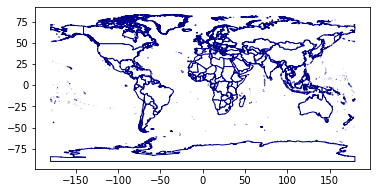

In [3]:
gpkg_src = 'https://bit.ly/2K4JcsB'
world = gpd.read_file(gpkg_src)
world.plot(facecolor='white', edgecolor='darkblue')

In [4]:
#world.to_file('world.gpkg', driver='GPKG')
#world.to_file('world.shp', driver='ESRI Shapefile')
world.to_file('world.geojson', driver='GeoJSON')

In [5]:
print(isinstance(world.geometry, str))
print(isinstance(world.geometry, pd.Series))
print(isinstance(world.geometry, gpd.GeoSeries))

False
True
True


<AxesSubplot:>

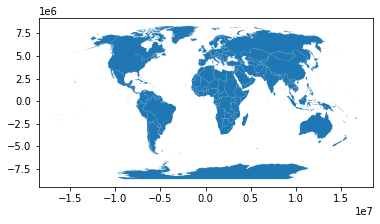

In [6]:
world2 = world.to_crs('ESRI:54030')
world2.plot()

<AxesSubplot:>

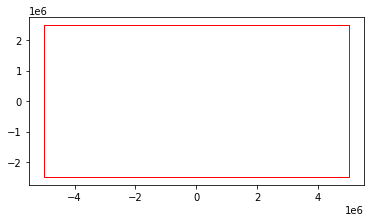

In [7]:
from shapely import wkt
bbox = 'POLYGON((5000000.0 2500000.0, 5000000.0 -2500000.0, -5000000.0 -2500000.0, -5000000.0 2500000.0, 5000000.0 2500000.0))'
bgdf = gpd.GeoDataFrame({'id':[0], 'coordinates':bbox})
bgdf['geometry'] = bgdf.coordinates.apply(wkt.loads)
bgdf = bgdf.set_crs('ESRI:54030')
bgdf.plot(edgecolor='red', facecolor='none')

(-3000000.0, 3000000.0)

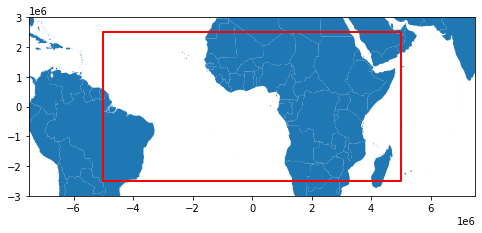

In [8]:
scale = int(float('1e7'))
f,ax=plt.subplots(figsize=(8,4))
world2.plot(ax=ax)
bgdf.plot(ax=ax, color='none', edgecolor='r', linewidth=2)
ax.set_xlim([-0.75*scale, +0.75*scale])
ax.set_ylim([-3*scale/10, +3*scale/10])

<AxesSubplot:>

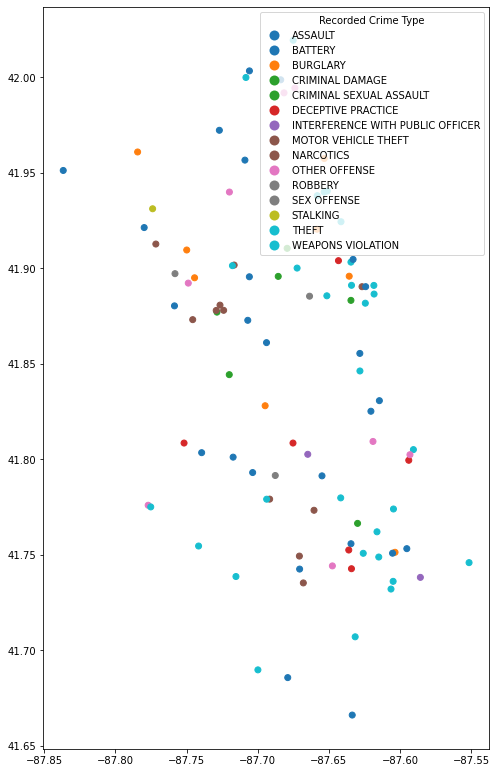

In [14]:
# If it times out, try downloading manually
url = 'https://github.com/jreades/i2p/raw/master/data/2019-sample-crime.csv'
df  = pd.read_csv(url)

gdf = gpd.GeoDataFrame(df, 
            geometry=gpd.points_from_xy(
                        df['Longitude'], 
                        df['Latitude'], 
                        crs='epsg:4326'
            )
      )
f,ax=plt.subplots(figsize=(8,16))
gdf.plot(ax=ax, column='Primary Type', legend=True, legend_kwds={'loc':'upper right', 'title':'Recorded Crime Type'})

## Dealing with Much Larger Volumes Data

Lots of interesting data to be found on the [Chicago Data Portal](https://data.cityofchicago.org/)

In [12]:
wd = %pwd
print(wd)

/home/jovyan/work/i2p-private/live


#### Census Tracts

In [6]:
#tracts = gpd.read_file( 'https://data.cityofchicago.org/api/geospatial/5jrd-6zik?method=export&format=Original' )
#tracts.to_file(os.path.join('data','geo','Census Tracts.gpkg'), driver='GPKG')
#del(tracts)
#print("Done.")

epsg:3435


<AxesSubplot:>

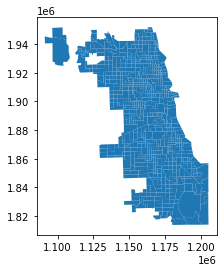

In [7]:
tracts = gpd.read_file(os.path.join('data','geo','Census Tracts.gpkg'))
print(tracts.crs)
tracts.plot()

#### Building Data

Here we can read building outlines for the entire city (it's a big file, ~200MB Zipped), so I made a smiplified version in QGIS. I could have done this in Python but wanted to experiment more and QGIS' rendering is faster. I also don't load all of the columns because some of them are no longer relevant after my buffering and merging.

In [ ]:
#bldgs = gpd.read_file( 'https://data.cityofchicago.org/api/geospatial/hz9b-7nh8?method=export&format=Original' )
#bldgs.to_file(os.path.join('data','raw','buildings','buildings.shp'))

epsg:3435


<AxesSubplot:>

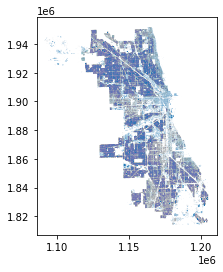

In [3]:
bldgs = gpd.read_file(os.path.join('data','raw','buildings','buildings.shp'))
bldgs.crs

<AxesSubplot:>

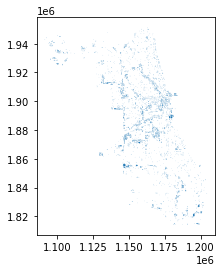

In [5]:
bldgs[bldgs.geometry.area > 30000].plot(figsize=(10,7)) # Another way to specify the figure size

In [7]:
# Set the column names we're interested in
cols = ['bldg_id','bldg_statu','f_add1','pre_dir1','st_name1','st_type1',
        'bldg_name1','bldg_name2','stories','bldg_creat','x_coord','y_coord',
        'no_of_unit','no_stories','year_built', 'geometry']

# Work out the ones we don't need using *not in*
to_drop = [x.upper() for x in bldgs.columns.values if x.lower() not in cols]
print(to_drop)

['CDB_CITY_I', 'T_ADD1', 'UNIT_NAME', 'NON_STANDA', 'COMMENTS', 'ORIG_BLDG_', 'FOOTPRINT_', 'CREATE_USE', 'BLDG_ACTIV', 'BLDG_END_D', 'DEMOLISHED', 'EDIT_DATE', 'EDIT_USERI', 'EDIT_SOURC', 'QC_DATE', 'QC_USERID', 'QC_SOURCE', 'Z_COORD', 'HARRIS_STR', 'BLDG_SQ_FO', 'BLDG_CONDI', 'CONDITION_', 'VACANCY_ST', 'LABEL_HOUS', 'SUF_DIR1', 'SHAPE_AREA', 'SHAPE_LEN']


In [8]:
print(f"Dropping columns: {', '.join(to_drop)}")
bldgs = bldgs.drop(to_drop, axis=1)

Dropping columns: CDB_CITY_I, T_ADD1, UNIT_NAME, NON_STANDA, COMMENTS, ORIG_BLDG_, FOOTPRINT_, CREATE_USE, BLDG_ACTIV, BLDG_END_D, DEMOLISHED, EDIT_DATE, EDIT_USERI, EDIT_SOURC, QC_DATE, QC_USERID, QC_SOURCE, Z_COORD, HARRIS_STR, BLDG_SQ_FO, BLDG_CONDI, CONDITION_, VACANCY_ST, LABEL_HOUS, SUF_DIR1, SHAPE_AREA, SHAPE_LEN


In [11]:
# Rename the columns to lower case
bldgs.columns = [x.lower() for x in bldgs.columns.values]
bldgs.columns.values

array(['bldg_id', 'bldg_statu', 'f_add1', 'pre_dir1', 'st_name1',
       'st_type1', 'bldg_name1', 'bldg_name2', 'stories', 'bldg_creat',
       'x_coord', 'y_coord', 'no_of_unit', 'no_stories', 'year_built',
       'geometry'], dtype=object)

In [13]:
# Initialise to NaN so these will be ones we *don't* set
bldgs['street_nm'] = np.nan
bldgs['address']   = np.nan

array(['bldg_id', 'bldg_statu', 'f_add1', 'pre_dir1', 'st_name1',
       'st_type1', 'bldg_name1', 'bldg_name2', 'stories', 'bldg_creat',
       'x_coord', 'y_coord', 'no_of_unit', 'no_stories', 'year_built',
       'geometry', 'street_nm', 'address'], dtype=object)

In [17]:
bldgs['street_nm'] = bldgs.loc[
                        ~((bldgs.pre_dir1.isna()) | (bldgs.st_name1.isna()) | (bldgs.st_type1.isna())) 
                     ][['pre_dir1','st_name1','st_type1']].apply(lambda row: ' '.join(row.values), axis=1)
bldgs['address']   = bldgs.loc[
                        ~((bldgs.street_nm.isna()) | (bldgs.f_add1.isna()))
                     ][['f_add1','street_nm']].apply(lambda row: ' '.join(row.values.astype('str')), axis=1)

bldgs[['f_add1','pre_dir1','st_name1','st_type1','street_nm','address']].sample(15)

,f_add1,pre_dir1,st_name1,st_type1,street_nm,address
126625,0,None,None,None,NaN,NaN
179926,1637,W,NORTH,AVE,W NORTH AVE,1637 W NORTH AVE
480057,2110,N,WHIPPLE,ST,N WHIPPLE ST,2110 N WHIPPLE ST
629120,6723,S,EUCLID,AVE,S EUCLID AVE,6723 S EUCLID AVE
282445,4720,W,HURON,ST,W HURON ST,4720 W HURON ST
594487,7424,S,PHILLIPS,AVE,S PHILLIPS AVE,7424 S PHILLIPS AVE
261000,6812,S,WASHTENAW,AVE,S WASHTENAW AVE,6812 S WASHTENAW AVE
383692,0,None,None,None,NaN,NaN
769753,2124,W,ADDISON,ST,W ADDISON ST,2124 W ADDISON ST
694695,5401,N,MONTCLARE,AVE,N MONTCLARE AVE,5401 N MONTCLARE AVE


In [45]:
# Writing data of this size is *sloooooooooow* compared to QGIS

# 38 minutes to write the shapefile on my machine
bldgs.to_file(os.path.join('data','geo','buildings.shp'), driver='ESRI Shapefile')

# Not even sure how long this takes!
#bldgs.to_file(os.path.join('data','geo','buildings.gpkg'), driver='GPKG')

Dropping columns: {', '.join(to_drop)}


<Projected CRS: EPSG:3435>
Name: NAD83 / Illinois East (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Illinois - SPCS - E
- bounds: (-89.28, 37.06, -87.02, 42.5)
Coordinate Operation:
- name: SPCS83 Illinois East zone (US Survey feet)
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [69]:
df = pd.read_csv(os.path.join('data','raw','2019-crime.csv.gz'))
df.info()
gdf = gpd.GeoDataFrame(df, 
            geometry=gpd.points_from_xy(df['Longitude'], df['Latitude'], crs='epsg:4326'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260025 entries, 0 to 260024
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   ID                    260025 non-null  int64  
 1   Case Number           260025 non-null  object 
 2   Date                  260025 non-null  object 
 3   Block                 260025 non-null  object 
 4   IUCR                  260025 non-null  object 
 5   Primary Type          260025 non-null  object 
 6   Description           260025 non-null  object 
 7   Location Description  258928 non-null  object 
 8   Arrest                260025 non-null  bool   
 9   Domestic              260025 non-null  bool   
 10  Beat                  260025 non-null  int64  
 11  District              260025 non-null  int64  
 12  Ward                  260010 non-null  float64
 13  Community Area        260025 non-null  int64  
 14  FBI Code              260025 non-null  object 
 15  

In [80]:
gdf.drop(gdf[((gdf.Latitude.isna())|(gdf.Longitude.isna()))].index, axis=0, inplace=True)
gdf.drop(gdf[((gdf.Latitude < 41)|(gdf.Longitude < -89))].index, axis=0, inplace=True)

In [87]:
gdf = gdf.to_crs(bldgs.crs) # Reproject

<AxesSubplot:>

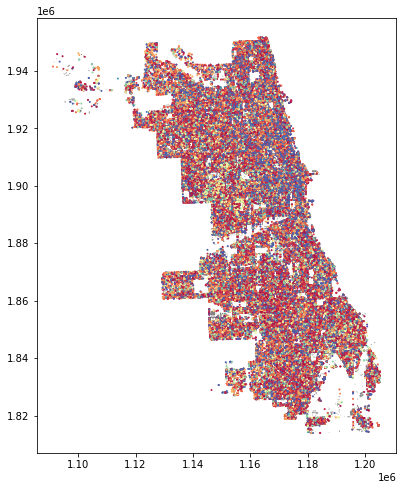

In [83]:
f,ax = plt.subplots(figsize=(12,8))
bldgs[bldgs.geometry.area > 30000].plot(ax=ax, edgecolor='none', facecolor=(0.4, 0.4, 0.4, 0.8))
gdf.plot(ax=ax, column='Primary Type', categorical=True, cmap='Spectral', markersize=1) #, legend=True)

In [113]:
scale  = int(float('1e6')) # This is the scale 
xmin = 1.17*scale
xmax = 1.174*scale
ymin = 1.868*scale
ymax = 1.872*scale
crime_slice = gdf.cx[xmin:xmax, ymin:ymax]
bldg_slice  = bldgs.cx[xmin:xmax, ymin:ymax]
tract_slice = tracts.cx[xmin:xmax, ymin:ymax]

<AxesSubplot:>

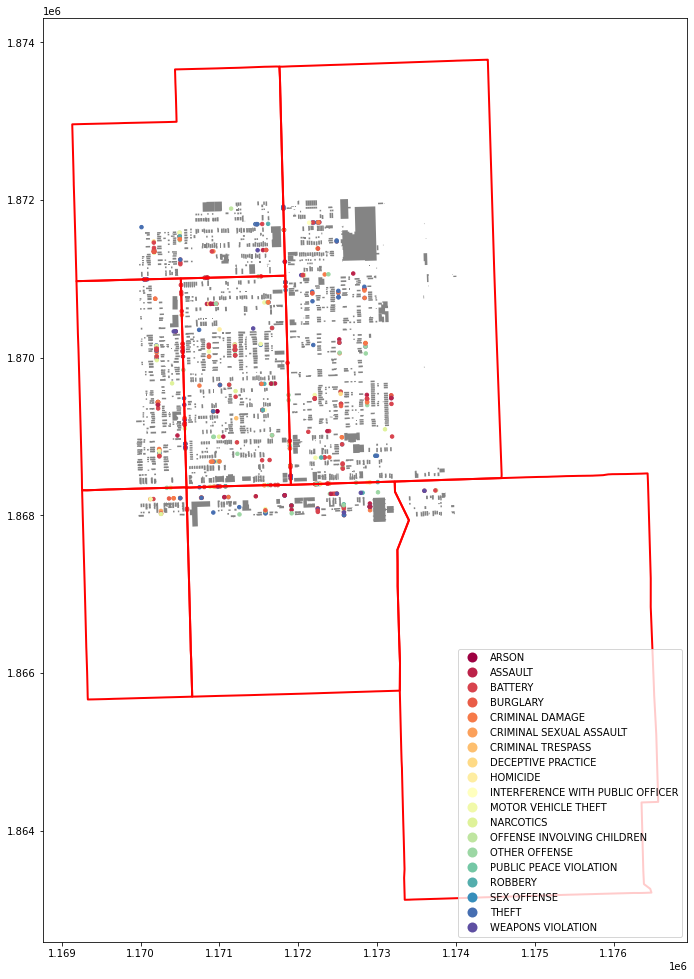

In [114]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f,ax = plt.subplots(figsize=(15,17))
bldg_slice.plot(ax=ax, edgecolor='none', facecolor=(0.4, 0.4, 0.4, 0.8))
crime_slice.plot(ax=ax, column='Primary Type', cmap='Spectral', markersize=12, legend=True, legend_kwds={'loc':'lower right'})
tract_slice.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)

(1868000.0, 1872000.0)

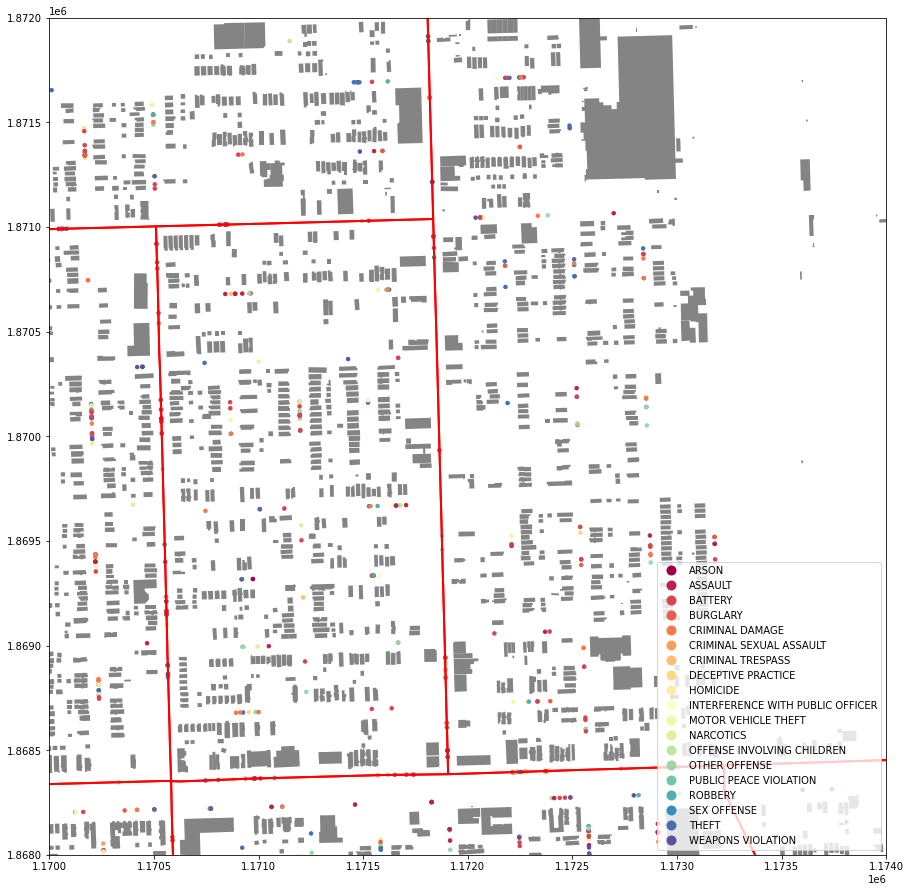

In [115]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
f,ax = plt.subplots(figsize=(15,17))
bldg_slice.plot(ax=ax, edgecolor='none', facecolor=(0.4, 0.4, 0.4, 0.8))
crime_slice.plot(ax=ax, column='Primary Type', cmap='Spectral', markersize=12, legend=True, legend_kwds={'loc':'lower right'})
tract_slice.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
ax.set_xlim([xmin, xmax])
ax.set_ylim([ymin, ymax])